### Parallel import of libraries

In [1]:
import re, os, sys, pickle
from pathlib import Path
import numpy
import pandas
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

from ChromosomeWindows import window
import genominterv

# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)

numpy.random.seed(7)

/home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Analysis dirs

In [2]:
root_dir = Path(os.environ['HOME'], 'simons/faststorage/people/kmt')
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
steps_dir = root_dir / 'steps'
argweaver_dir = steps_dir / 'argweaver/output'
results_dir = root_dir / 'results'
figures_dir = root_dir / 'figures'
data_dir = root_dir / 'data'
pi_dir = steps_dir / 'pi_stores'
dist_dir = steps_dir / 'dist_stores'
#pi_dir = root_dir / 'old_pi_stores'
male_x_haploid_dir = steps_dir / 'male_x_haploids'

### Local code in the scripts dir on the cluster

In [3]:
scripts_dir = root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

from toggle_code_and_errors import toggle_code_html, toggle_errors_html

### Convenience functions

In [4]:
def silent_nanmean(x):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return numpy.nanmean(x)

### Plotting setup

In [5]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
# from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

set1 = {'red': '#e41a1c', 'blue': '#377eb8', 'green': '#4daf4a',
        'purple': '#984ea3', 'orange': '#ff7f00', 
        'yellow': '#ffff33', 'brown': '#a65628'}

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kmt/anaconda3/e

In [6]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)

# Load meta data

In [7]:
# easy loading of meta data in a consistent manner across code
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=meta_data_dir)

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

# Load pi data and filter

In [42]:
pi_data_chrX = pandas.read_hdf(results_dir / 'pi_data_chrX.hdf', 'df')
pi_data_chr7 = pandas.read_hdf(results_dir / 'pi_data_chr7.hdf', 'df')

with open(str(results_dir / 'pi_filter_mask_chrX.npy'), 'rb') as f:
    pi_filter_mask_chrX = numpy.load(f)
with open(str(results_dir / 'pi_filter_mask_chr7.npy'), 'rb') as f:
    pi_filter_mask_chr7 = numpy.load(f)

# Call low pi regions

Using an absolute pi cutoff to find sweeps makes most sense since a sweep will reduce the diversity to a low absolute value not one relative to the population size. However we also do call sweeps using a relative cutoff to conservatively rule out that the regions found are just low regions due to BGS.

We use the following max pi cutoffs, conservatively assuming an X/A ratio of 0.5

In [43]:
X_A_ratio = 0.75 # NB: I changed this from 0.5 to 0.75. It would actually need to be 1 to be cons
abs_maxpi_chrX = 0.0001
abs_maxpi_chr7 = abs_maxpi_chrX / X_A_ratio
print("X/A ratio: {}\ncutoff chrX: {}\ncutoff chr7: {}".format(X_A_ratio, abs_maxpi_chrX, abs_maxpi_chr7))

rel_maxpi = 0.2 # reduction to 20% diversity

X/A ratio: 0.75
cutoff chrX: 0.0001
cutoff chr7: 0.00013333333333333334


We make **two** data frames for each chromsome: One with start and end for each called low region and one with all the windows (like the pi data frame) but with masked pi values and annotation about if it is a low window and a number to label each run of low / non-low windows.

### Run length cutoff for low pi regions

Min number of consequetive windows with low pi

In [44]:
min_run_length = 5
with open(str(results_dir / 'min_run_length.pkl'), 'wb') as f:
    pickle.dump(min_run_length, f)

In [45]:
def call_low_pi_regions(df, mask, criterion):
    df = (df
              .loc[:, ['chrom', 'start', 'end', 'pop_label', 'region_label', 'pi']]
              .assign(pi = lambda df: df.pi.where(~mask)) 
              .groupby(['chrom', 'start', 'end', 'pop_label', 'region_label'])
              .aggregate(silent_nanmean)
              .reset_index(['chrom', 'start', 'end', 'pop_label', 'region_label'])
             )

    window_group_df_list = list()
    region_group_df_list = list()
    cols = ['chrom', 'pop_label', 'region_label']
    for name, group in df.groupby(cols):
        
        # add meta stats for computing runs
        meta_df = (group
#                   .reset_index(level=cols)
                  .reset_index(drop=True)
                  .assign(run = 1, 
                          islow = criterion) # turn masked into nan to break runs at missing data
                  .assign(run_id = lambda df: (df.islow != df.islow.shift()).cumsum())
                   )
        # make data frame with the low pi regions
        region_df = (meta_df
                  .groupby(['chrom', 'pop_label', 'region_label', 'run_id'])
                  .aggregate({'start': 'min', 'end': 'max', 'run': 'sum', 'pi': 'mean'})
                  .reset_index(level=['chrom', 'pop_label', 'region_label', 'run_id'])
                  .loc[criterion]
             )
        region_group_df_list.append(region_df)
        
        def add_run_length(df):
            # turn the run into the sum of run (i.e. the length 
            # of the region that the window is part of)
            _df = df.loc[:]
            _df['run'] = _df['run'].sum()
            return _df
    
        window_df = (meta_df
                     .groupby(['chrom', 'pop_label', 'region_label', 'run_id'])
                     .apply(add_run_length)
#                      .reset_index(level=['chrom', 'pop_label', 'region_label', 'run_id'])
                     .reset_index()
                    )        
        window_group_df_list.append(window_df)

        
    low_region_df = pandas.concat(region_group_df_list)
    low_window_df = pandas.concat(window_group_df_list)

    pop_categories = pandas.read_hdf(str(results_dir / 'population_categories.store'), 'sr')
    region_categories = pandas.read_hdf(str(results_dir / 'region_categories.store'), 'sr')

    low_region_df['region'] = pandas.Categorical(low_region_df.region_label, 
                                                 categories=region_categories, ordered=True)
    low_region_df['population'] = pandas.Categorical(low_region_df.pop_label, 
                                                     categories=pop_categories, ordered=True)

    low_window_df['region'] = pandas.Categorical(low_window_df.region_label, 
                                                 categories=region_categories, ordered=True)
    low_window_df['population'] = pandas.Categorical(low_window_df.pop_label, 
                                                     categories=pop_categories, ordered=True)

    low_window_df['is_low_region'] = (low_window_df.islow) & (low_window_df.run >= min_run_length)
    
    
    return low_region_df, low_window_df

### Absolute pi cutoff

In [46]:
abs_low_region_chrX_df, abs_low_window_chrX_df = call_low_pi_regions(pi_data_chrX, 
                                                      pi_filter_mask_chrX, 
                                                      criterion = lambda df: df.pi <= abs_maxpi_chrX)

abs_low_region_chrX_df.to_hdf(results_dir / 'abs_low_region_chrX_df.hdf', 'df', format='table', mode='w')
abs_low_window_chrX_df.to_hdf(results_dir / 'abs_low_window_chrX_df.hdf', 'df', format='table', mode='w')

abs_low_region_chr7_df, abs_low_window_chr7_df = call_low_pi_regions(pi_data_chr7, 
                                                      pi_filter_mask_chr7, 
                                                      criterion = lambda df: df.pi <= abs_maxpi_chr7)

abs_low_region_chr7_df.to_hdf(results_dir / 'abs_low_region_chr7_df.hdf', 'df', format='table', mode='w')
abs_low_window_chr7_df.to_hdf(results_dir / 'abs_low_window_chr7_df.hdf', 'df', format='table', mode='w')


abs_low_region_df = pandas.concat([abs_low_region_chrX_df, abs_low_region_chr7_df])

### Relative pi cutoff

In [47]:
rel_low_region_chrX_df, rel_low_window_chrX_df = call_low_pi_regions(pi_data_chrX, 
                                                      pi_filter_mask_chrX, 
                                                      criterion = lambda df: df.pi <= df.pi.mean() * rel_maxpi)

rel_low_region_chrX_df.to_hdf(results_dir / 'rel_low_region_chrX_df.hdf', 'df', format='table', mode='w')
rel_low_window_chrX_df.to_hdf(results_dir / 'rel_low_window_chrX_df.hdf', 'df', format='table', mode='w')

rel_low_region_chr7_df, rel_low_window_chr7_df = call_low_pi_regions(pi_data_chr7, 
                                                      pi_filter_mask_chr7, 
                                                      criterion = lambda df: df.pi <= df.pi.mean() * rel_maxpi)

rel_low_region_chr7_df.to_hdf(results_dir / 'rel_low_region_chr7_df.hdf', 'df', format='table', mode='w')
rel_low_window_chr7_df.to_hdf(results_dir / 'rel_low_window_chr7_df.hdf', 'df', format='table', mode='w')


rel_low_region_df = pandas.concat([rel_low_region_chrX_df, rel_low_region_chr7_df])

# Length distributions of low pi regions

### Absolute pi cutoff

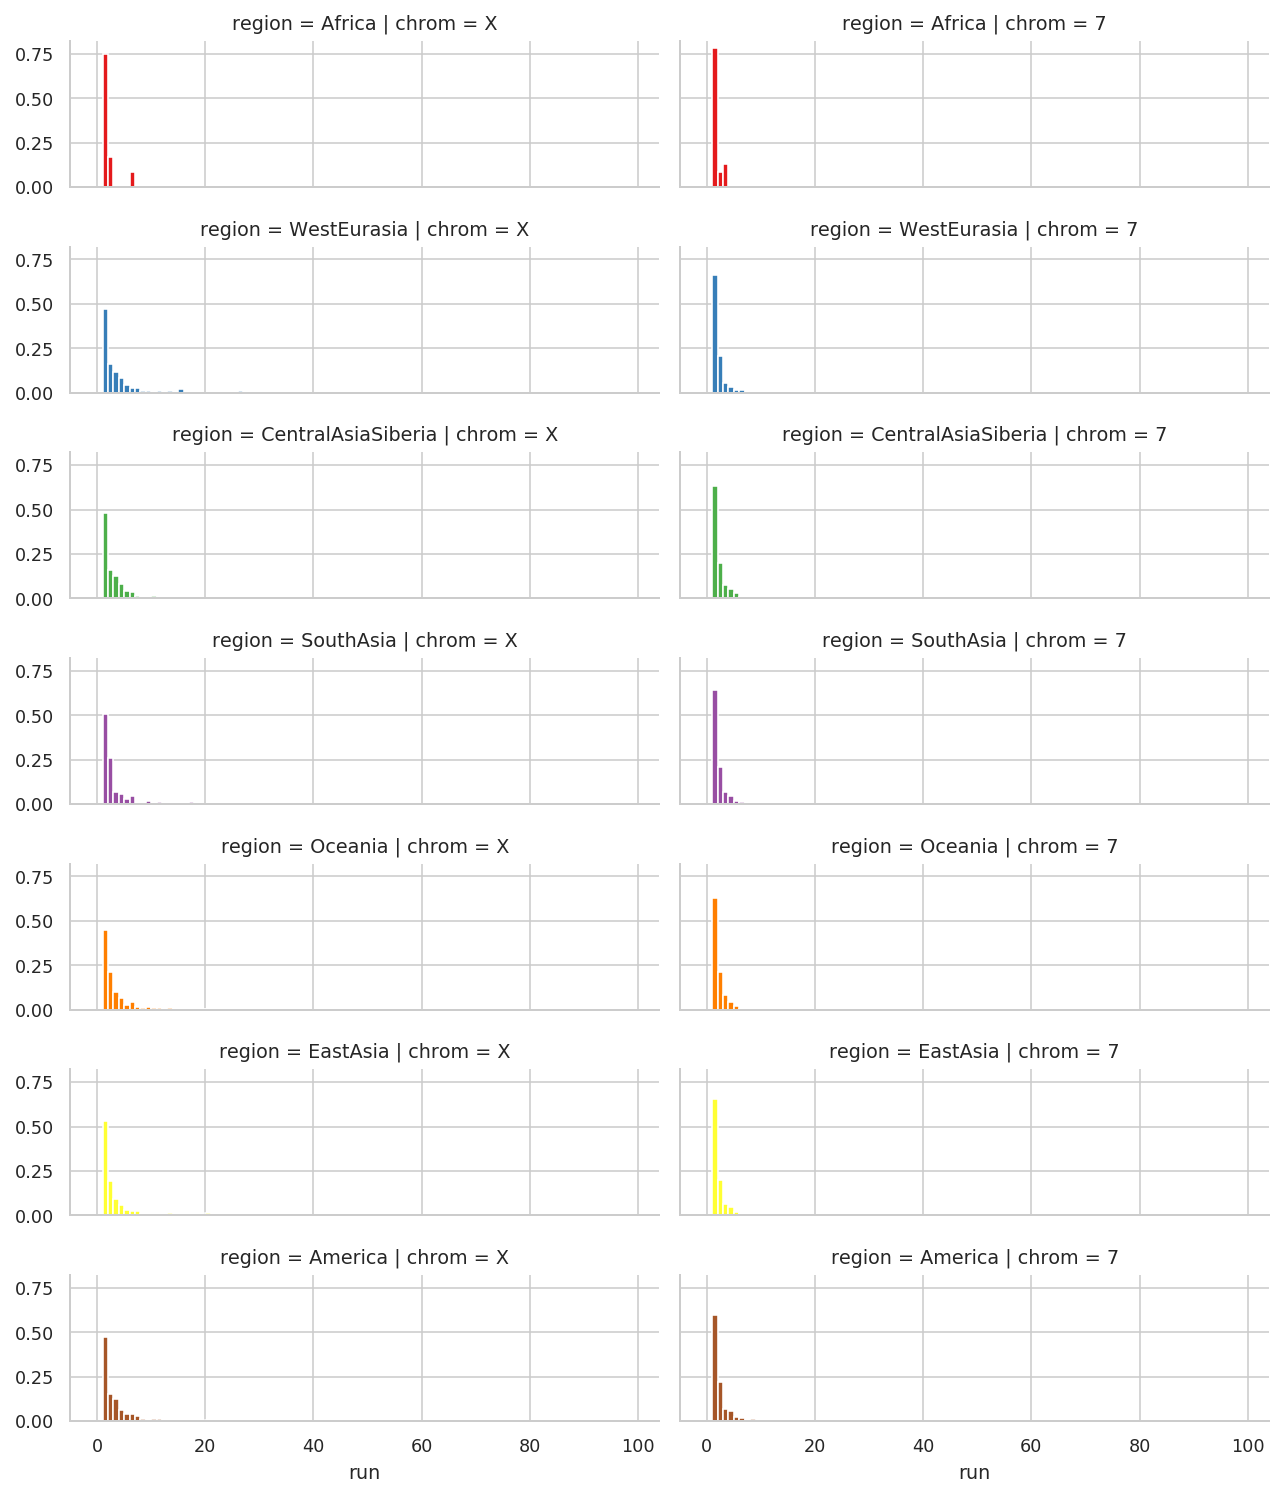

In [48]:
g = sns.FacetGrid(abs_low_region_df, row="region", col='chrom', hue="region", 
                  height=1.5, aspect=3, palette='Set1')
g = g.map(plt.hist, 'run', bins=range(0, 100, 1), density=True)
plt.savefig(str(figures_dir / "length_dist_abs_low_regions.pdf"))

### Relative pi cutoff

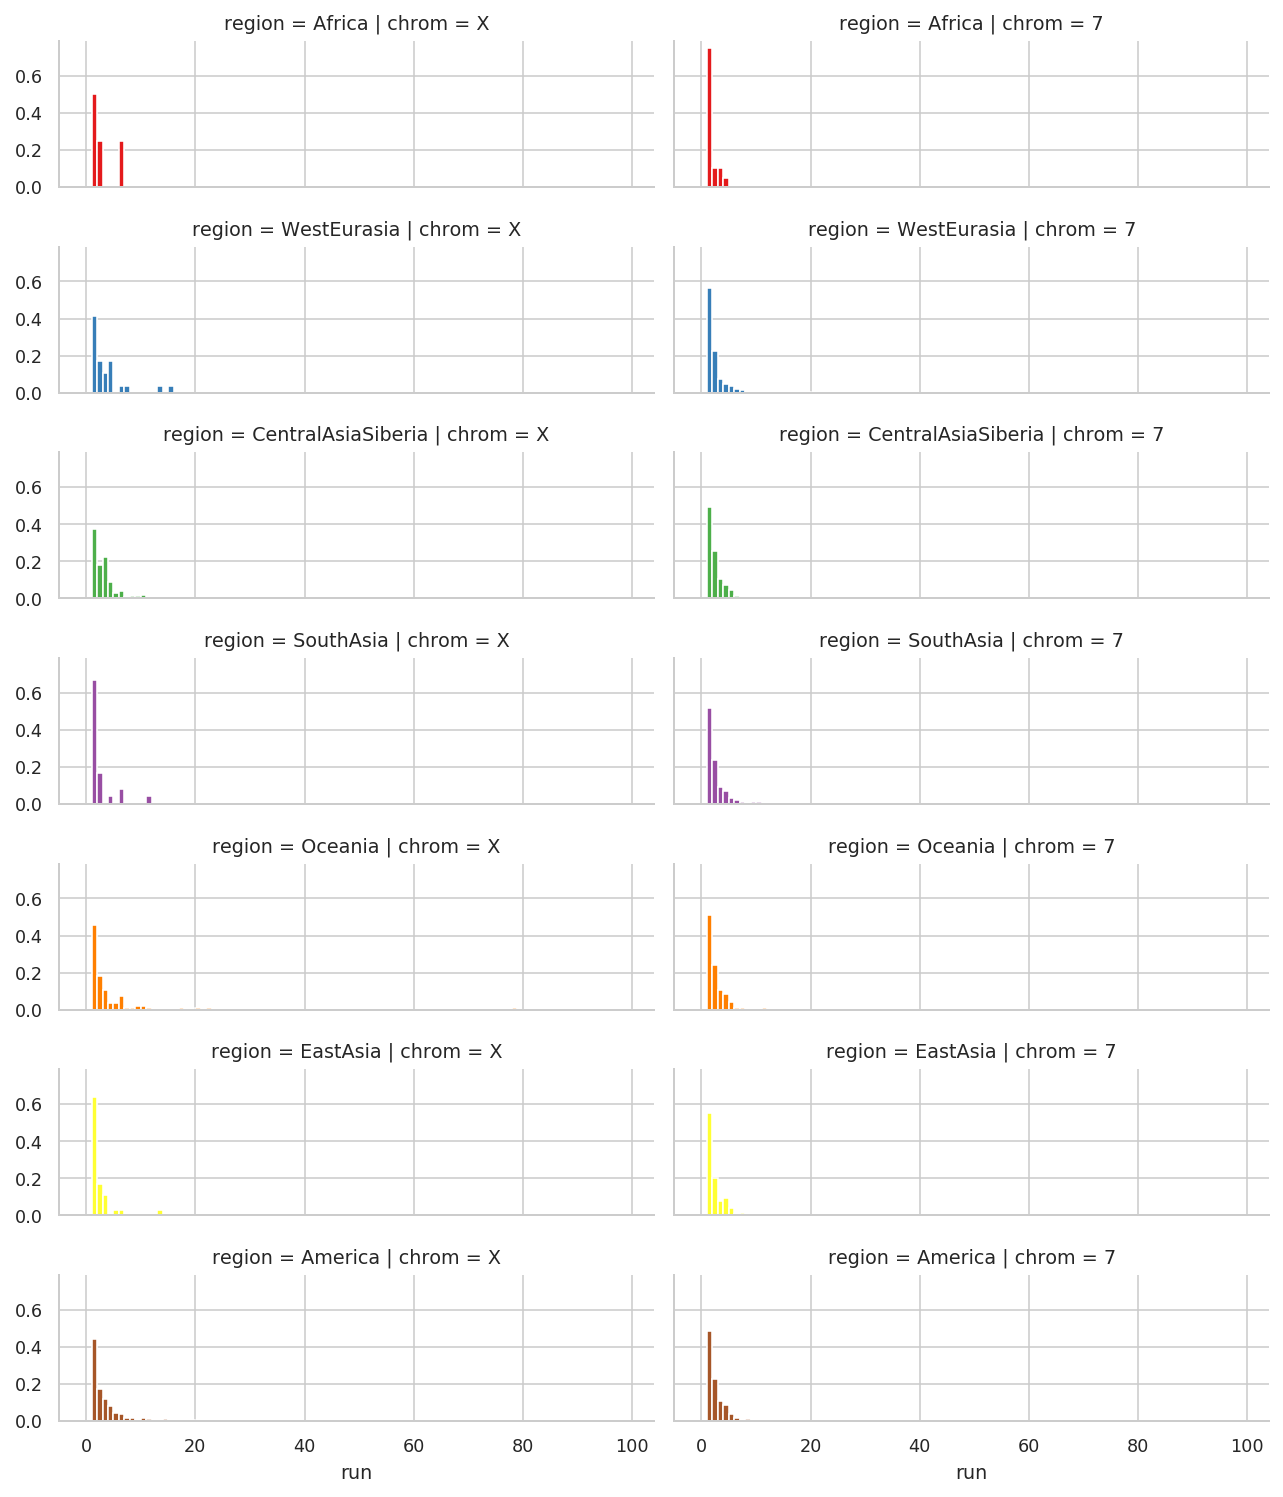

In [49]:
g = sns.FacetGrid(rel_low_region_df, row="region", col='chrom', hue="region", 
                  height=1.5, aspect=3, palette='Set1')
g = g.map(plt.hist, 'run', bins=range(0, 100, 1), density=True)
plt.savefig(str(figures_dir / "length_dist_rel_low_regions.pdf"))

### Absolute pi cutoff

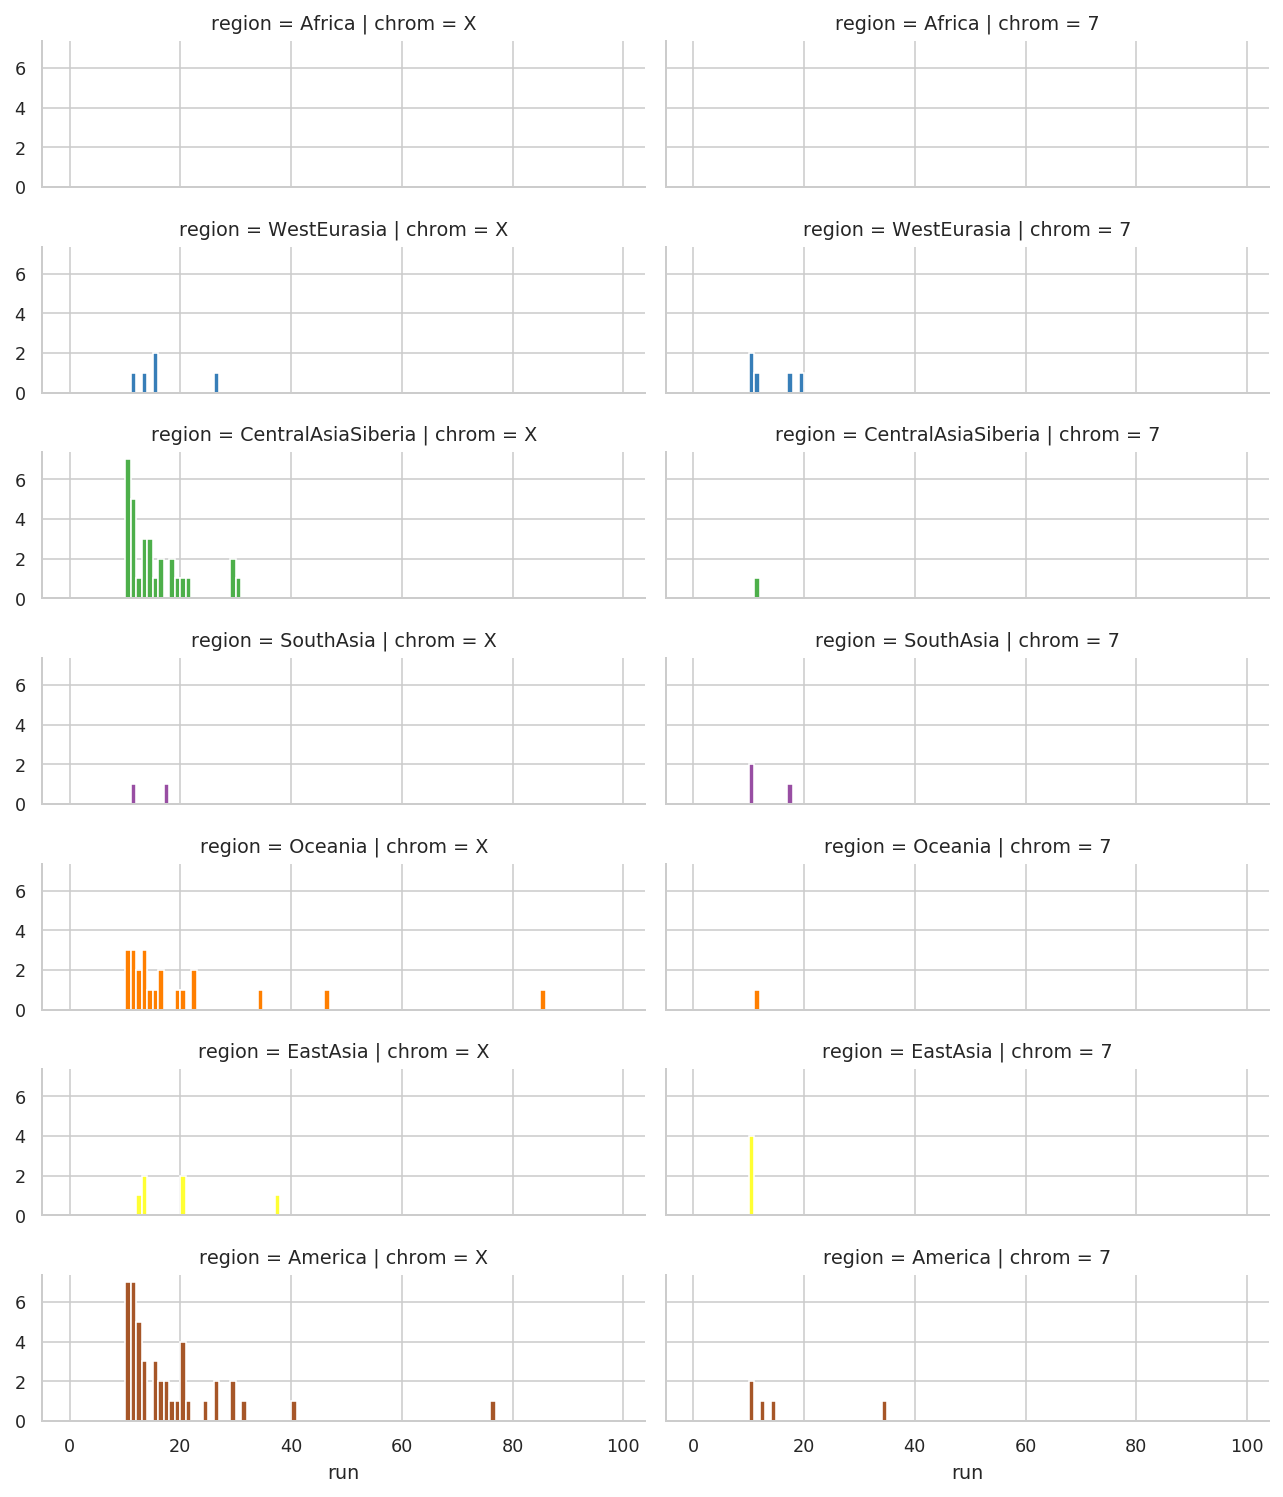

In [50]:
g = sns.FacetGrid(abs_low_region_df.loc[abs_low_region_df.run >= 10], row="region", col='chrom', hue="region", 
                  height=1.5, aspect=3, palette='Set1')
g = g.map(plt.hist, 'run', bins=range(0, 100, 1), density=False)
plt.savefig(str(figures_dir / "length_dist_abs_low_regions_trucated.pdf"))

### Relative pi cutoff

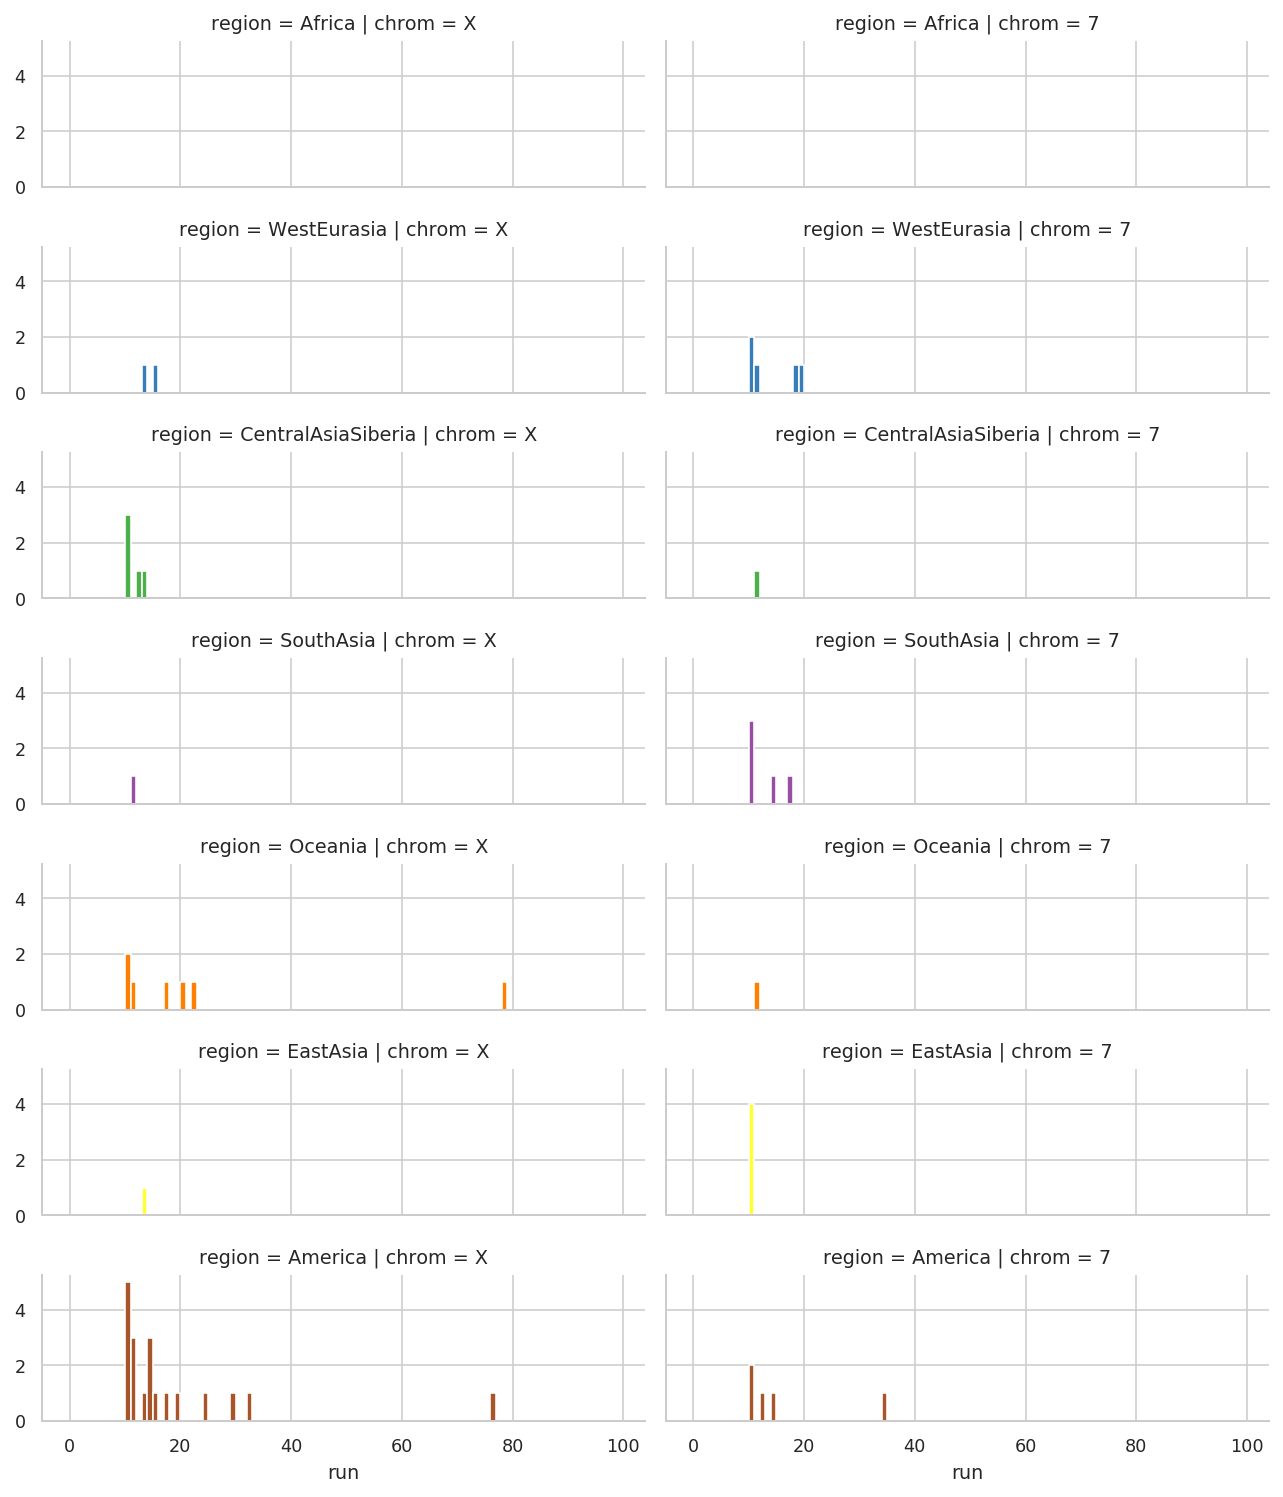

In [51]:
g = sns.FacetGrid(rel_low_region_df.loc[rel_low_region_df.run >= 10], row="region", col='chrom', hue="region", 
                  height=1.5, aspect=3, palette='Set1')
g = g.map(plt.hist, 'run', bins=range(0, 100, 1), density=False)
plt.savefig(str(figures_dir / "length_dist_rel_low_regions_trucated.pdf"))

# Runs of low pi windows

### Runs of _absolute_ low pi windows on chrX

In [52]:
# Load population and region categories written by scripts/build_pi_datasets.py
pop_categories = pandas.read_hdf(str(results_dir / 'population_categories.store'), 'sr')
region_categories = pandas.read_hdf(str(results_dir / 'region_categories.store'), 'sr')
# region_colors = dict(zip(list(region_categories), 
#                          ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']))

region_colors = dict(zip(list(region_categories), 
                         ['#e41a1c', '#377eb8',  '#984ea3', '#4daf4a',
                          '#ff7f00', '#ffff33', '#a65628']))

In [53]:
# Load meta data
ampliconic_regions = pandas.read_hdf(str(results_dir / 'ampliconic_regions.hdf'))
refseq_density = pandas.read_hdf(str(results_dir / 'refseq_density.hdf'))
no_neanderthal_eur =  pandas.read_hdf(str(results_dir / 'no_neanderthal_eur.hdf'))
no_neanderthal_asn =  pandas.read_hdf(str(results_dir / 'no_neanderthal_asn.hdf'))
                                          
human_chimp_low_ils_regions_chrX = pandas.read_hdf(str(results_dir / 'human_chimp_low_ils_regions_chrX.hdf'))
human_chimp_low_ils_regions_chr7 = pandas.read_hdf(str(results_dir / 'human_chimp_low_ils_regions_chr7.hdf'))
human_orang_low_ils_regions_chrX = pandas.read_hdf(str(results_dir / 'human_orang_low_ils_regions_chrX.hdf'))
human_orang_low_ils_regions_chr7 = pandas.read_hdf(str(results_dir / 'human_orang_low_ils_regions_chr7.hdf'))
akey_regions = pandas.read_hdf(str(results_dir / 'akey_regions.hdf'))

admix_1Mb_windows_chrX =  pandas.read_hdf(str(results_dir / 'admix_1Mb_windows_chrX.hdf'))                                                                   

admix alphas are truncated at 10%
exon density alphas are truncated at 10%


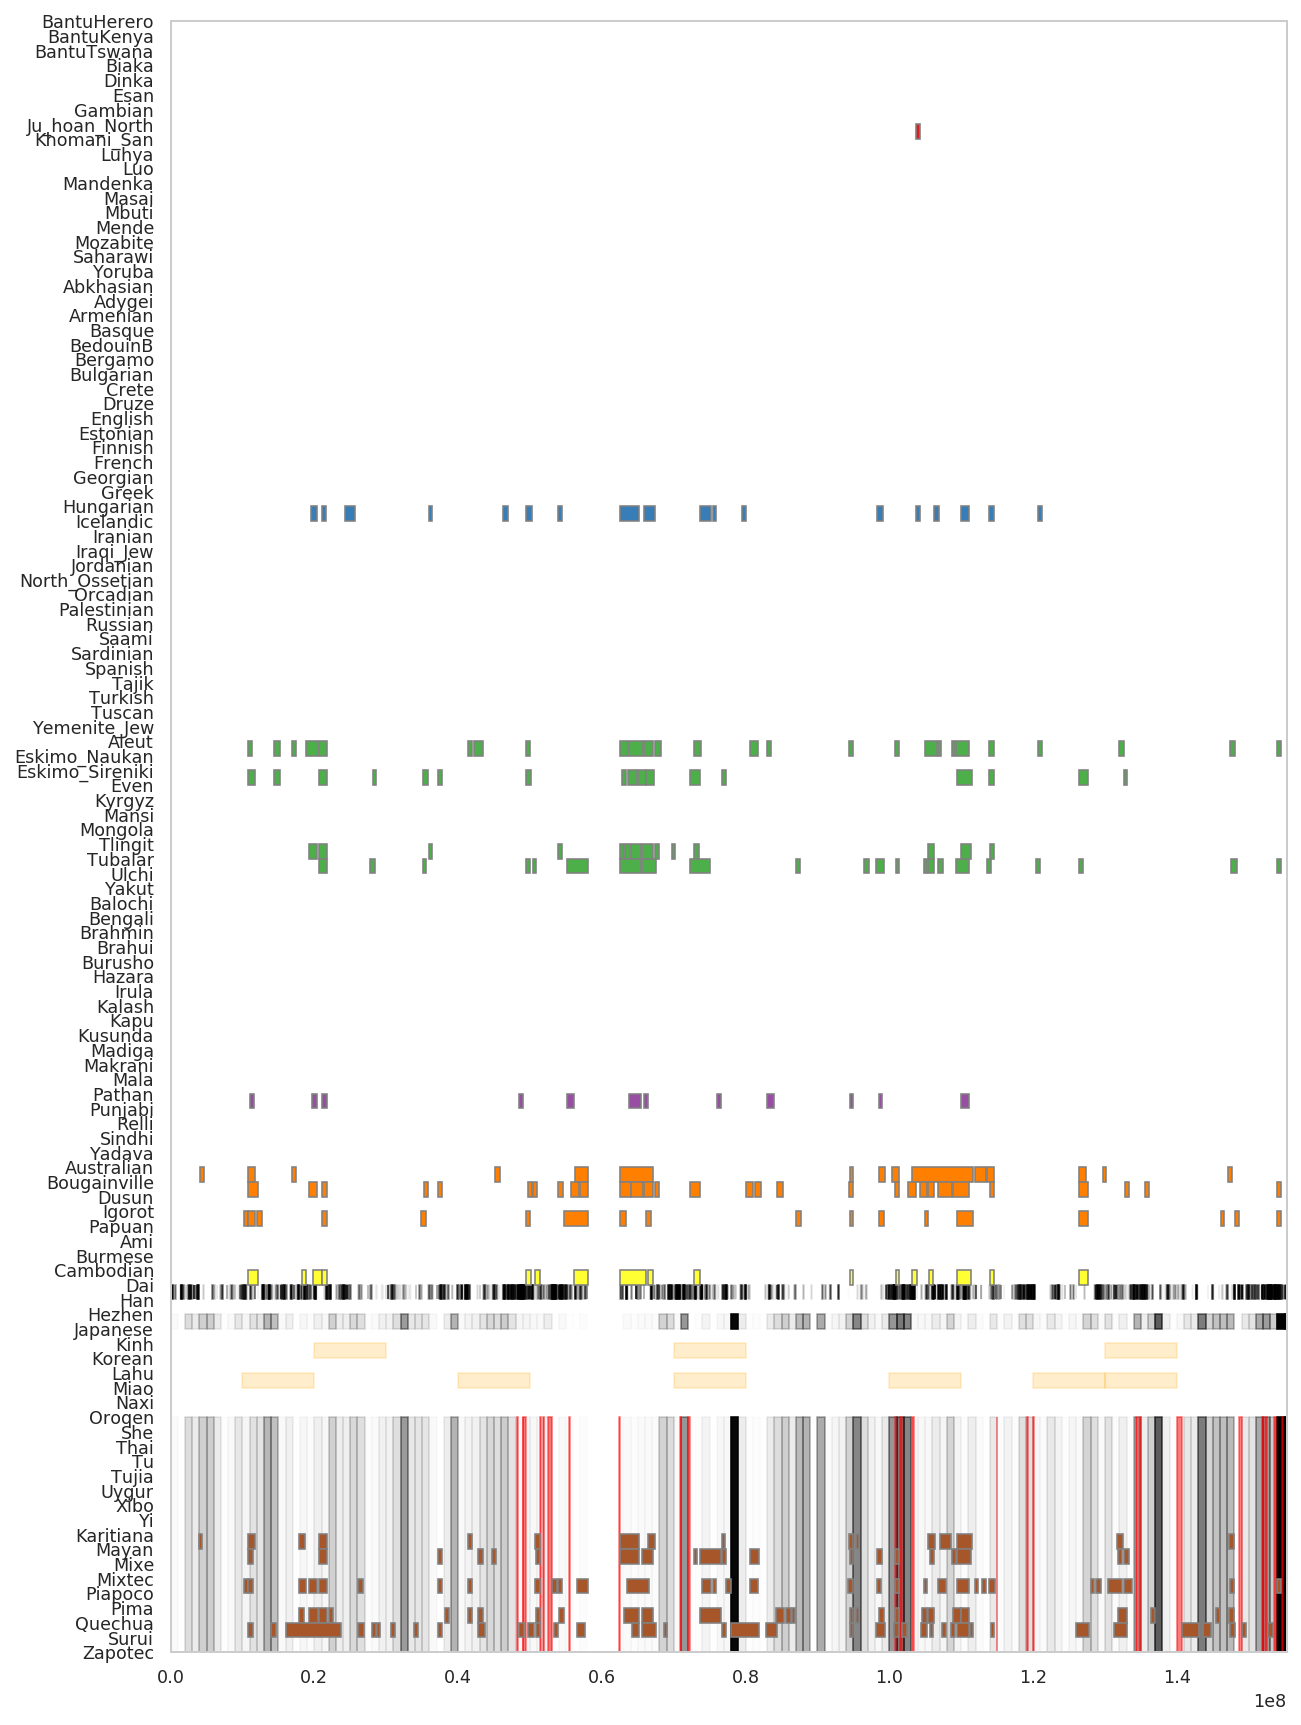

In [54]:

nr_populations = pi_data_chrX.population.drop_duplicates().size
chrom_size = chromosome_lengths['X']

region_colors = dict(zip(list(region_categories), 
                         ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']))

with sns.plotting_context('paper'):
    with sns.axes_style("whitegrid", {'axes.grid' : False}):
        fig, ax = plt.subplots(figsize=(10,15))

        ax.set_xlim([0, chrom_size])
        ax.set_ylim([0, nr_populations])

        ax.set_ylim([0, nr_populations+10])

        # Shriram no european neanderthal admixture top line
        for segm in no_neanderthal_eur.loc[lambda df: df.chrom == 'X'].itertuples():
            g = ax.add_patch(Rectangle((segm.start, nr_populations+2), segm.end-segm.start, 1, 
                                          facecolor='orange', edgecolor='orange', alpha=0.2, zorder=0))
    
        # Shriram no asian neanderthal admixture top line
        for segm in no_neanderthal_asn.loc[lambda df: df.chrom == 'X'].itertuples():
            g = ax.add_patch(Rectangle((segm.start, nr_populations+4), segm.end-segm.start, 1, 
                                          facecolor='orange', edgecolor='orange', alpha=0.2, zorder=0))

        # global admix proportion
        admix_global_1Mb_means_chrX = (admix_1Mb_windows_chrX
                                      .groupby(['chrom', 'start'])
                                      .aggregate(numpy.mean)
                                      .reset_index()
                                     )
        print("admix alphas are truncated at 10%")
        # top line
        for segm in admix_global_1Mb_means_chrX.itertuples():
            g = ax.add_patch(Rectangle((segm.start, nr_populations+6), segm.end-segm.start, 1, 
                                          facecolor='black', edgecolor='black', alpha=min(segm.admix_prop*10, 1), zorder=0))
        # background
        for segm in admix_global_1Mb_means_chrX.itertuples():
            g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, nr_populations, 
                                          facecolor='black', edgecolor='black', alpha=min(segm.admix_prop*10, 1), zorder=0))

            
            
        print("exon density alphas are truncated at 10%")
        # exon density top line
        for segm in refseq_density.loc[lambda df: df.chrom == 'X'].itertuples():
            g = ax.add_patch(Rectangle((segm.start, nr_populations+8), segm.end-segm.start, 1, 
                                          facecolor='black', edgecolor='black', alpha=min(segm.exon_density*10, 1), zorder=0))

#         # regional admixture proportion
#         for segm in region_admix_prop_with_pops.itertuples():
#             y = pop_categories.size - segm.pop_code - 1
#             g = ax.add_patch(Rectangle((segm.start, y), segm.end-segm.start, 1, 
#                                           facecolor='black', edgecolor='black', alpha=segm.admix_prop*10, zorder=0))

            

            
#         collapsed_long_segments = GenomicIntervals.interval_collapse(abs_low_region_df.loc[(abs_low_region_df.chrom == 'X') & (low_region_df.run >= min_run_length)])
#         for segm in collapsed_long_segments.itertuples():
#             g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, nr_populations, 
#                                           facecolor='pink', edgecolor='pink', alpha=0.3, zorder=0))
            

        for segm in abs_low_region_df.loc[abs_low_region_df.chrom == 'X'].assign(pop_code=lambda df: df.population.cat.codes).itertuples():
            if segm.run >= min_run_length:
                y = pop_categories.size - segm.pop_code - 1
                g = ax.add_patch(Rectangle((segm.start, y), segm.end-segm.start, 1, 
                                              facecolor=region_colors[segm.region_label], edgecolor='grey'))

                
#         # human chimp low ils:
#         for segm in human_chimp_low_ils_regions_chrX.itertuples():
#             g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, nr_populations, 
#                                           facecolor='grey', edgecolor='grey', alpha=0.3, zorder=0))
#         # human orang low ils:        
#         for segm in human_orang_low_ils_regions_chrX.itertuples():
#             g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, nr_populations, 
#                                           facecolor='grey', edgecolor='grey', alpha=0.15, zorder=0))

        for segm in ampliconic_regions.loc[lambda df: df.chrom == 'X'].itertuples():
            g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, nr_populations, 
                                          facecolor='red', edgecolor='red', alpha=0.5, zorder=0))



#         for segm in no_neanderthal_eur.loc[lambda df: df.chrom == 'X'].itertuples():
#             g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, nr_populations, 
#                                           facecolor='orange', edgecolor='orange', alpha=0.2, zorder=0))

#         for segm in no_neanderthal_asn.loc[lambda df: df.chrom == 'X'].itertuples():
#             g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, nr_populations, 
#                                           facecolor='orange', edgecolor='orange', alpha=0.2, zorder=0))

#         sp = tuple(x in ['EC', 'WLG', 'SO'] for x in low_ape_pi_regions.species)
#         ape_regions = low_ape_pi_regions.loc[lambda df: (df.chrom == 'X') & sp]

#         for segm in ape_regions.itertuples():
#             g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, nr_populations, 
#                                           facecolor='green', edgecolor='green', alpha=0.2, zorder=0))
                        

        plt.yticks(range(pop_categories.size), reversed(list(pop_categories)))

        plt.savefig(str(figures_dir / "abs_low_regions_map_chrX.pdf"))


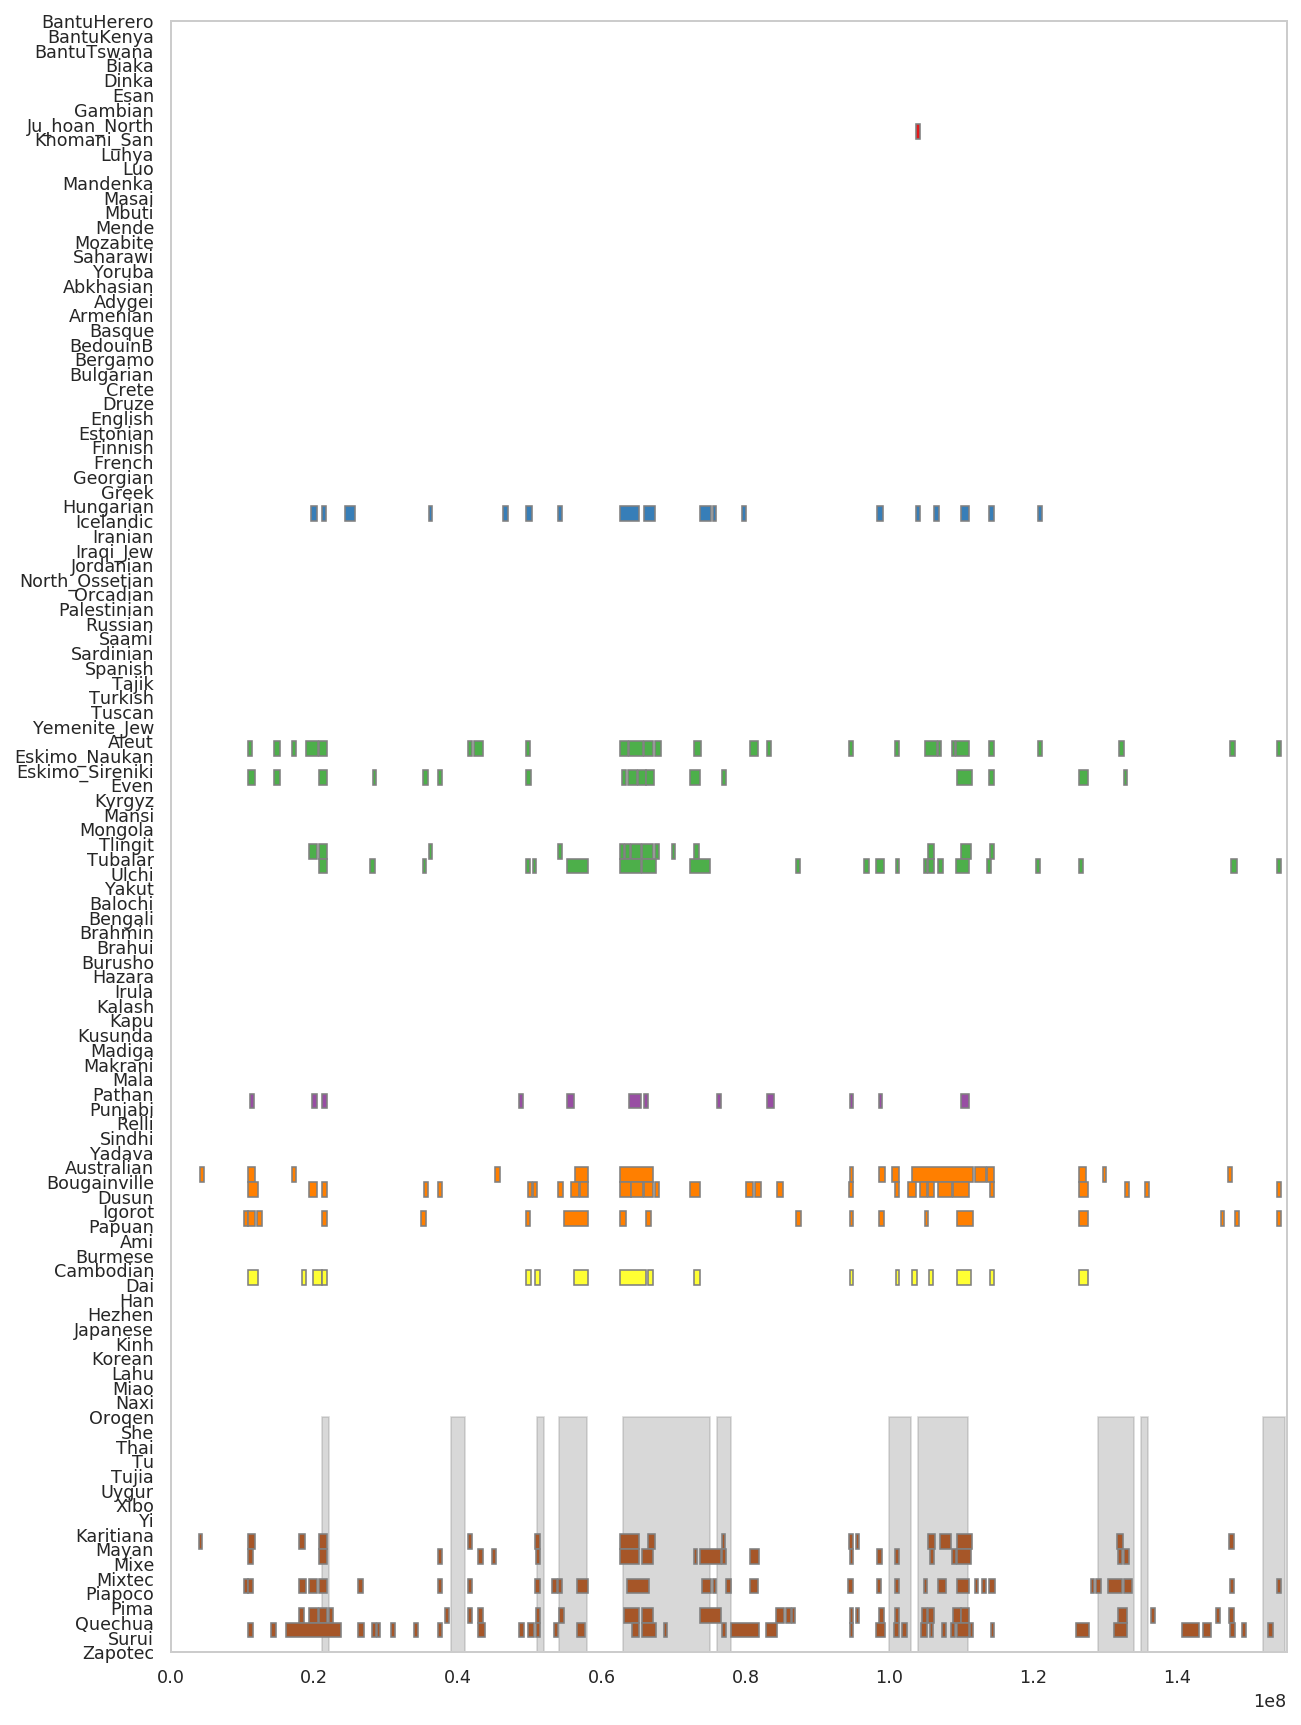

In [55]:

nr_populations = pi_data_chrX.population.drop_duplicates().size
chrom_size = chromosome_lengths['X']

region_colors = dict(zip(list(region_categories), 
                         ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']))

with sns.plotting_context('paper'):
    with sns.axes_style("whitegrid", {'axes.grid' : False}):
        fig, ax = plt.subplots(figsize=(10,15))

        ax.set_xlim([0, chrom_size])
        ax.set_ylim([0, nr_populations])

#        ax.set_ylim([0, nr_populations+10])

#         # Shriram no european neanderthal admixture top line
#         for segm in no_neanderthal_eur.loc[lambda df: df.chrom == 'X'].itertuples():
#             g = ax.add_patch(Rectangle((segm.start, nr_populations+2), segm.end-segm.start, 1, 
#                                           facecolor='orange', edgecolor='orange', alpha=0.2, zorder=0))
    
#         # Shriram no asian neanderthal admixture top line
#         for segm in no_neanderthal_asn.loc[lambda df: df.chrom == 'X'].itertuples():
#             g = ax.add_patch(Rectangle((segm.start, nr_populations+4), segm.end-segm.start, 1, 
#                                           facecolor='orange', edgecolor='orange', alpha=0.2, zorder=0))

#         # global admix proportion
#         admix_global_1Mb_means_chrX = (admix_1Mb_windows_chrX
#                                       .groupby(['chrom', 'start'])
#                                       .aggregate(numpy.mean)
#                                       .reset_index()
#                                      )
#         # top line
#         for segm in admix_global_1Mb_means_chrX.itertuples():
#             g = ax.add_patch(Rectangle((segm.start, nr_populations+6), segm.end-segm.start, 1, 
#                                           facecolor='black', edgecolor='black', alpha=segm.admix_prop*10, zorder=0))
#         # background
#         for segm in admix_global_1Mb_means_chrX.itertuples():
#             g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, nr_populations, 
#                                           facecolor='black', edgecolor='black', alpha=segm.admix_prop*10, zorder=0))

            
            
#         # exon density top line
#         for segm in refseq_density.loc[lambda df: df.chrom == 'X'].itertuples():
#             g = ax.add_patch(Rectangle((segm.start, nr_populations+8), segm.end-segm.start, 1, 
#                                           facecolor='black', edgecolor='black', alpha=segm.exon_density*10, zorder=0))

#         # regional admixture proportion
#         for segm in region_admix_prop_with_pops.itertuples():
#             y = pop_categories.size - segm.pop_code - 1
#             g = ax.add_patch(Rectangle((segm.start, y), segm.end-segm.start, 1, 
#                                           facecolor='black', edgecolor='black', alpha=segm.admix_prop*10, zorder=0))

            

            
#         collapsed_long_segments = GenomicIntervals.interval_collapse(abs_low_region_df.loc[(abs_low_region_df.chrom == 'X') & (low_region_df.run >= min_run_length)])
#         for segm in collapsed_long_segments.itertuples():
#             g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, nr_populations, 
#                                           facecolor='pink', edgecolor='pink', alpha=0.3, zorder=0))
            

        for segm in abs_low_region_df.loc[abs_low_region_df.chrom == 'X'].assign(pop_code=lambda df: df.population.cat.codes).itertuples():
            if segm.run >= min_run_length:
                y = pop_categories.size - segm.pop_code - 1
                g = ax.add_patch(Rectangle((segm.start, y), segm.end-segm.start, 1, 
                                              facecolor=region_colors[segm.region_label], edgecolor='grey'))

                
        # human chimp low ils:
        for segm in human_chimp_low_ils_regions_chrX.itertuples():
            g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, nr_populations, 
                                          facecolor='grey', edgecolor='grey', alpha=0.3, zorder=0))
#         # human orang low ils:        
#         for segm in human_orang_low_ils_regions_chrX.itertuples():
#             g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, nr_populations, 
#                                           facecolor='grey', edgecolor='grey', alpha=0.15, zorder=0))

#         for segm in ampliconic_regions.loc[lambda df: df.chrom == 'X'].itertuples():
#             g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, nr_populations, 
#                                           facecolor='red', edgecolor='red', alpha=0.5, zorder=0))

#         # Akey regions:        
#         for segm in akey_regions[akey_regions.chrom == 'X'].itertuples():
#             g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, nr_populations, 
#                                           facecolor='pink', edgecolor='pink', alpha=0.5, zorder=0))


#         for segm in no_neanderthal_eur.loc[lambda df: df.chrom == 'X'].itertuples():
#             g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, nr_populations, 
#                                           facecolor='orange', edgecolor='orange', alpha=0.2, zorder=0))

#         for segm in no_neanderthal_asn.loc[lambda df: df.chrom == 'X'].itertuples():
#             g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, nr_populations, 
#                                           facecolor='orange', edgecolor='orange', alpha=0.2, zorder=0))

#         sp = tuple(x in ['EC', 'WLG', 'SO'] for x in low_ape_pi_regions.species)
#         ape_regions = low_ape_pi_regions.loc[lambda df: (df.chrom == 'X') & sp]

#         for segm in ape_regions.itertuples():
#             g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, nr_populations, 
#                                           facecolor='green', edgecolor='green', alpha=0.2, zorder=0))
                        

        plt.yticks(range(pop_categories.size), reversed(list(pop_categories)))

        plt.savefig(str(figures_dir / "abs_low_regions_map_chrX.pdf"))


### Runs of _absolute_ low pi windows on chr7

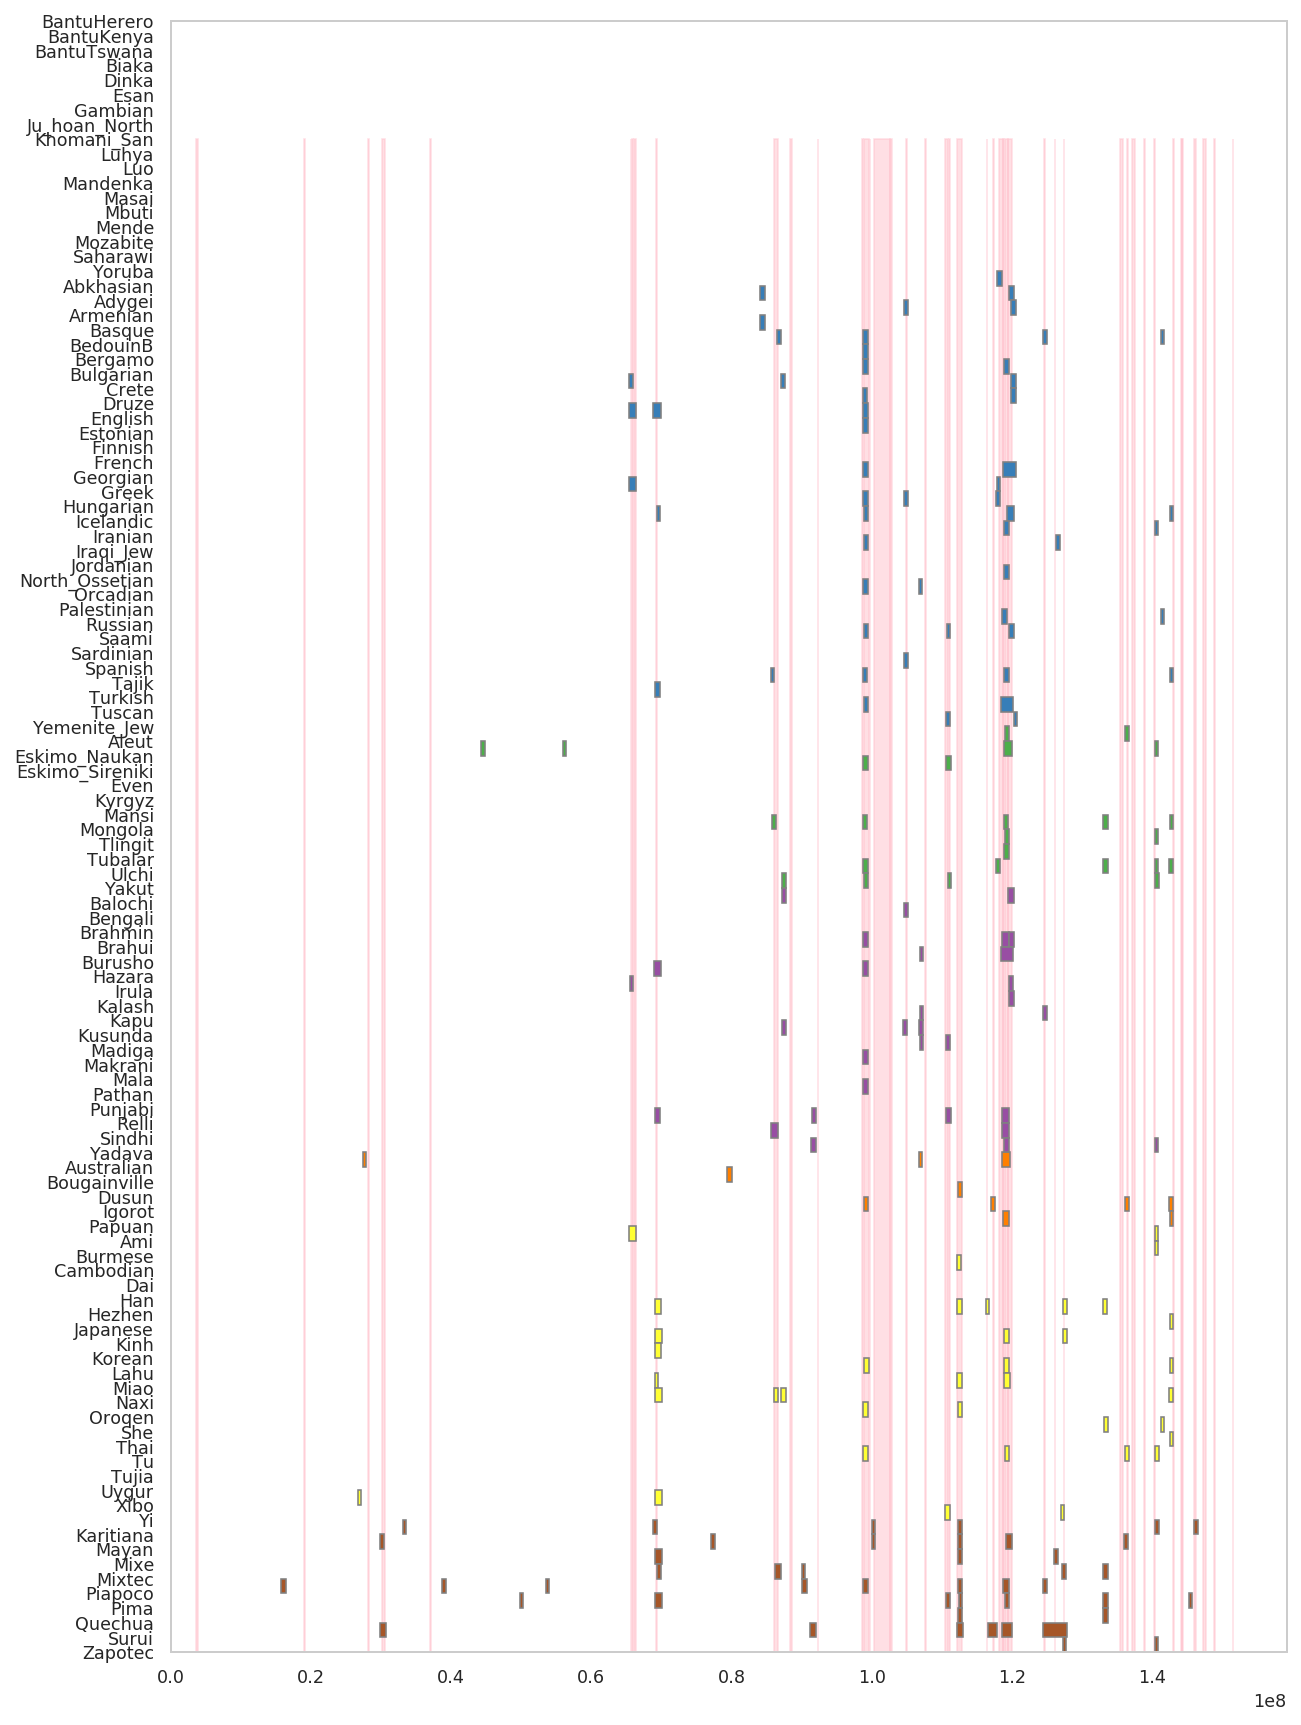

In [56]:

nr_populations = pi_data_chr7.population.drop_duplicates().size
chrom_size = chromosome_lengths['7']

with sns.plotting_context('paper'):
    with sns.axes_style("whitegrid", {'axes.grid' : False}):
        fig, ax = plt.subplots(figsize=(10,15))
        ax.set_xlim([0, chrom_size])
        ax.set_ylim([0, nr_populations])

        for segm in abs_low_region_df.loc[abs_low_region_df.chrom == '7'].assign(pop_code=lambda df: df.population.cat.codes).itertuples():
            if segm.run >= min_run_length:
                y = pop_categories.size - segm.pop_code - 1
                g = ax.add_patch(Rectangle((segm.start, y), segm.end-segm.start, 1, 
                                              facecolor=region_colors[segm.region_label], edgecolor='grey'))
                                
        # human chimp low ils:
        for segm in human_chimp_low_ils_regions_chr7.itertuples():
            g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, nr_populations, 
                                          facecolor='grey', edgecolor='grey', alpha=0.3, zorder=0))
        # human orang low ils:        
        for segm in human_orang_low_ils_regions_chr7.itertuples():
            g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, nr_populations, 
                                          facecolor='grey', edgecolor='grey', alpha=0.15, zorder=0))

        # Akey regions:        
        for segm in akey_regions[akey_regions.chrom == '7'].itertuples():
            g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, nr_populations, 
                                          facecolor='pink', edgecolor='pink', alpha=0.5, zorder=0))
            
            
        plt.yticks(range(pop_categories.size), reversed(list(pop_categories)))

        plt.savefig(str(figures_dir / "abs_low_regions_map_chr7.pdf"))


### Runs of _relative_ low pi windows on chrX

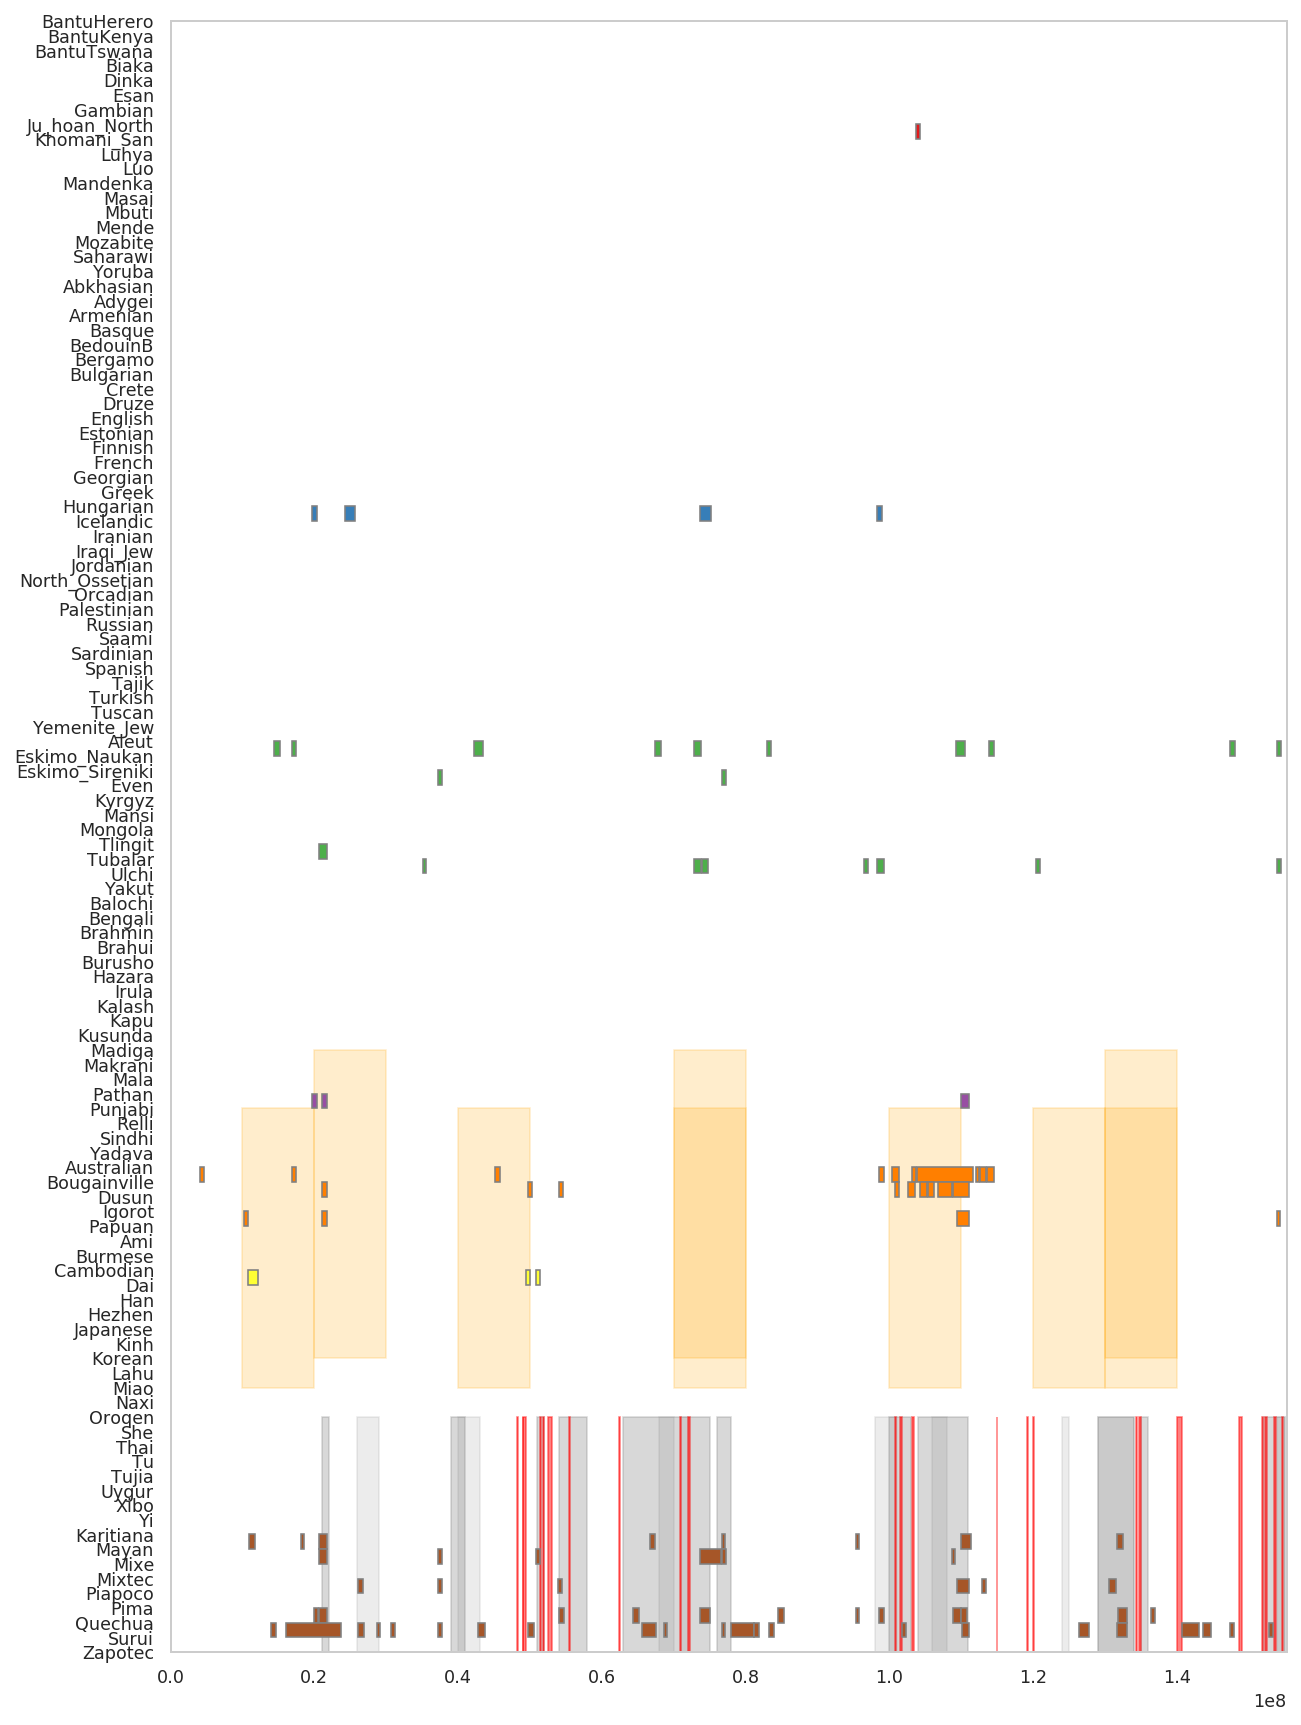

In [57]:

nr_populations = pi_data_chrX.population.drop_duplicates().size
chrom_size = chromosome_lengths['X']

region_colors = dict(zip(list(region_categories), 
                         ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']))

with sns.plotting_context('paper'):
    with sns.axes_style("whitegrid", {'axes.grid' : False}):
        fig, ax = plt.subplots(figsize=(10,15))

        ax.set_xlim([0, chrom_size])
        ax.set_ylim([0, nr_populations])

        ax.set_ylim([0, nr_populations+6])
        for segm in no_neanderthal_eur.loc[lambda df: df.chrom == 'X'].itertuples():
            g = ax.add_patch(Rectangle((segm.start, nr_populations+2), segm.end-segm.start, nr_populations+3, 
                                          facecolor='orange', edgecolor='orange', alpha=0.2, zorder=0))

        for segm in no_neanderthal_asn.loc[lambda df: df.chrom == 'X'].itertuples():
            g = ax.add_patch(Rectangle((segm.start, nr_populations+4), segm.end-segm.start, nr_populations+5, 
                                          facecolor='orange', edgecolor='orange', alpha=0.2, zorder=0))


#         collapsed_long_segments = GenomicIntervals.interval_collapse(rel_low_region_df.loc[(rel_low_region_df.chrom == 'X') & (low_region_df.run >= 5)])
#         for segm in collapsed_long_segments.itertuples():
#             g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, nr_populations, 
#                                           facecolor='pink', edgecolor='pink', alpha=0.3, zorder=0))
            

        for segm in rel_low_region_df.loc[rel_low_region_df.chrom == 'X'].assign(pop_code=lambda df: df.population.cat.codes).itertuples():
            if segm.run >= 5:
                y = pop_categories.size - segm.pop_code - 1
                g = ax.add_patch(Rectangle((segm.start, y), segm.end-segm.start, 1, 
                                              facecolor=region_colors[segm.region_label], edgecolor='grey'))

        # human chimp low ils:
        for segm in human_chimp_low_ils_regions_chrX.itertuples():
            g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, nr_populations, 
                                          facecolor='grey', edgecolor='grey', alpha=0.3, zorder=0))
        # human orang low ils:        
        for segm in human_orang_low_ils_regions_chrX.itertuples():
            g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, nr_populations, 
                                          facecolor='grey', edgecolor='grey', alpha=0.15, zorder=0))

        for segm in ampliconic_regions.loc[lambda df: df.chrom == 'X'].itertuples():
            g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, nr_populations, 
                                          facecolor='red', edgecolor='red', alpha=0.5, zorder=0))

#         for segm in no_neanderthal_eur.loc[lambda df: df.chrom == 'X'].itertuples():
#             g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, nr_populations, 
#                                           facecolor='orange', edgecolor='orange', alpha=0.2, zorder=0))

#         for segm in no_neanderthal_asn.loc[lambda df: df.chrom == 'X'].itertuples():
#             g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, nr_populations, 
#                                           facecolor='orange', edgecolor='orange', alpha=0.2, zorder=0))

#         sp = tuple(x in ['EC', 'WLG', 'SO'] for x in low_ape_pi_regions.species)
#         ape_regions = low_ape_pi_regions.loc[lambda df: (df.chrom == 'X') & sp]

#         for segm in ape_regions.itertuples():
#             g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, nr_populations, 
#                                           facecolor='green', edgecolor='green', alpha=0.2, zorder=0))
                        

        plt.yticks(range(pop_categories.size), reversed(list(pop_categories)))

        plt.savefig(str(figures_dir / "rel_low_regions_map_chrX.pdf"))


### Runs of _relative_ low pi windows on chr7

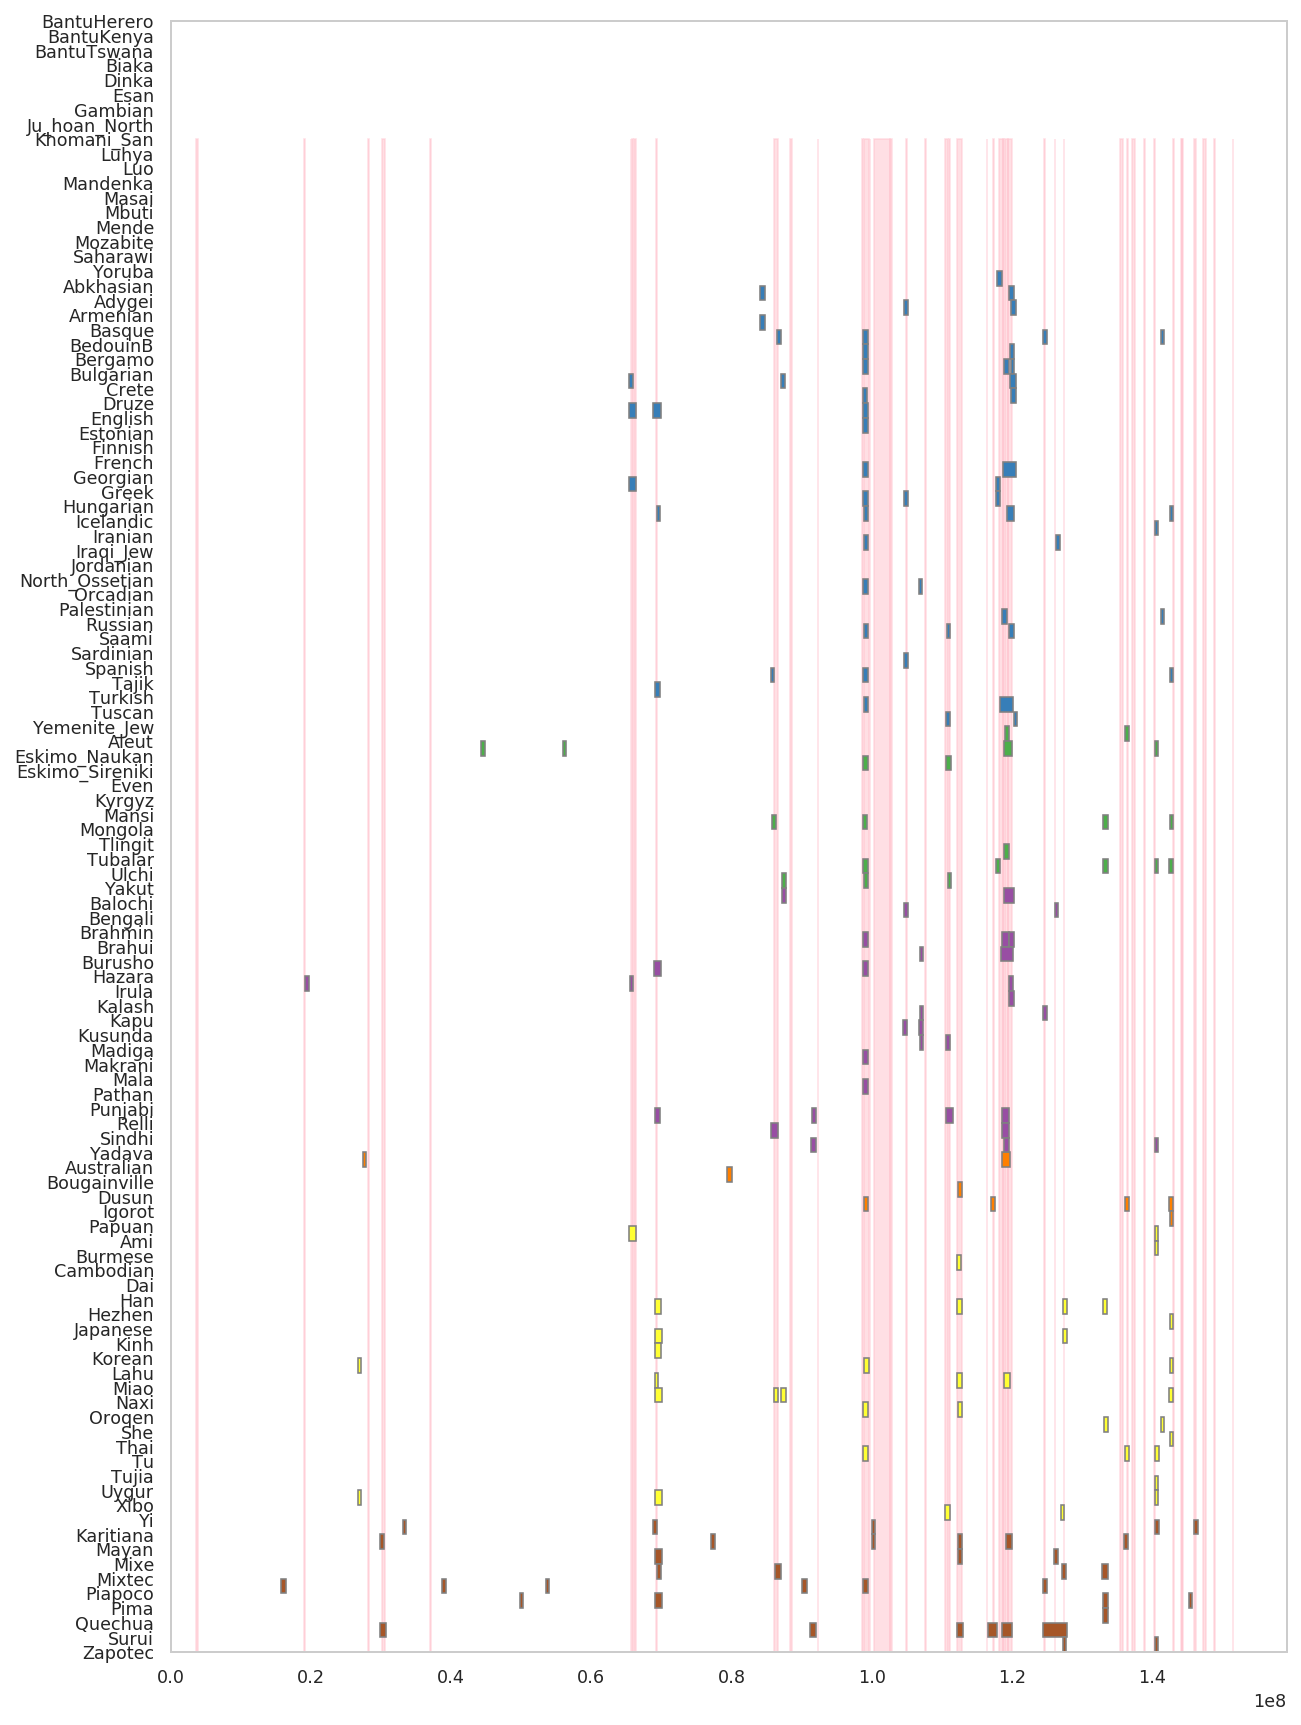

In [58]:

nr_populations = pi_data_chr7.population.drop_duplicates().size
chrom_size = chromosome_lengths['7']

with sns.plotting_context('paper'):
    with sns.axes_style("whitegrid", {'axes.grid' : False}):
        fig, ax = plt.subplots(figsize=(10,15))
        ax.set_xlim([0, chrom_size])
        ax.set_ylim([0, nr_populations])

        for segm in rel_low_region_df.loc[rel_low_region_df.chrom == '7'].assign(pop_code=lambda df: df.population.cat.codes).itertuples():
            if segm.run >= min_run_length:
                y = pop_categories.size - segm.pop_code - 1
                g = ax.add_patch(Rectangle((segm.start, y), segm.end-segm.start, 1, 
                                              facecolor=region_colors[segm.region_label], edgecolor='grey'))
                
        # human chimp low ils:
        for segm in human_chimp_low_ils_regions_chr7.itertuples():
            g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, nr_populations, 
                                          facecolor='grey', edgecolor='grey', alpha=0.3, zorder=0))
        # human orang low ils:        
        for segm in human_orang_low_ils_regions_chr7.itertuples():
            g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, nr_populations, 
                                          facecolor='grey', edgecolor='grey', alpha=0.15, zorder=0))
            
        # Akey regions:        
        for segm in akey_regions[akey_regions.chrom == '7'].itertuples():
            g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, nr_populations, 
                                          facecolor='pink', edgecolor='pink', alpha=0.5, zorder=0))
        
        plt.yticks(range(pop_categories.size), reversed(list(pop_categories)))

        plt.savefig(str(figures_dir / "rel_low_regions_map_chr7.pdf"))


### Relative TMRCA_half

In [59]:
tmrca_stats = pandas.read_hdf(results_dir / 'tmrca_stats.hdf')

In [60]:
#abs_low_window_chrX_df = pandas.read_hdf(results_dir / 'abs_low_window_chrX_df.hdf')
#min_run_length = 5

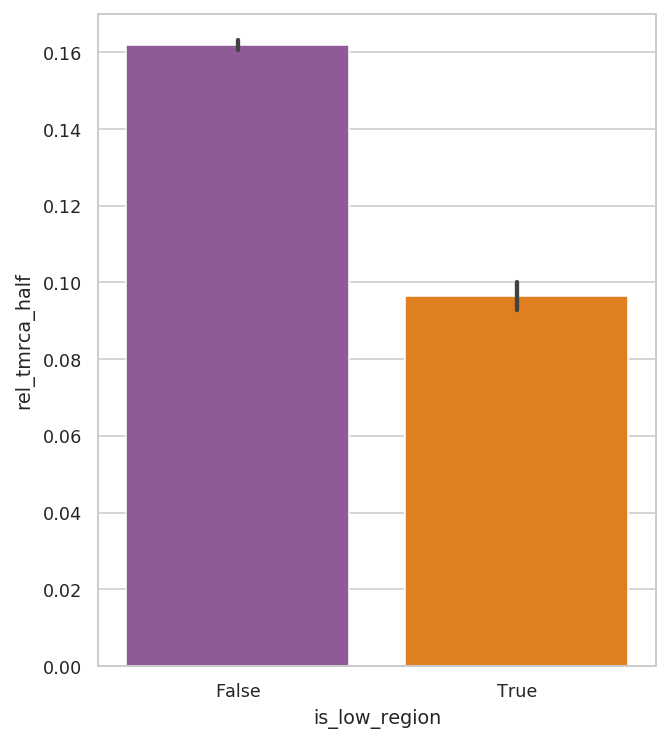

In [61]:
with sns.plotting_context('paper'):
    with sns.axes_style('whitegrid'):
        with sns.color_palette([set1['purple'], set1['orange']]):
            df = (pandas.merge(abs_low_window_chrX_df,
                               tmrca_stats.loc[lambda df: df.region == 'World', ['start', 'end', 'rel_tmrca_half', 'tmrca']],
                               on=['start', 'end'],
                               how='left'
                              )
                    .assign(is_low_region = lambda df: (df.islow) & (df.run >= min_run_length))
                 )
            fig, ax = plt.subplots(1,1, figsize=(5,6))
            sns.barplot(x="is_low_region", y="rel_tmrca_half", data=df, ax=ax);
            plt.ylim((0, 0.17))
plt.savefig(str(figures_dir / "tmrca_half_contrast.pdf"))

Relative TMRCA_half is clearly lower in the low pi regions. One could argue that I already partitioned into regions with low and high rel_tmrca_half but that is not true. What I did was to partition into regions that show low diversity in *one* population, and what I then show is that the low diversity regions are not low simply due to lower global Ne in the region, but that they are enriched for recent coalescence events.

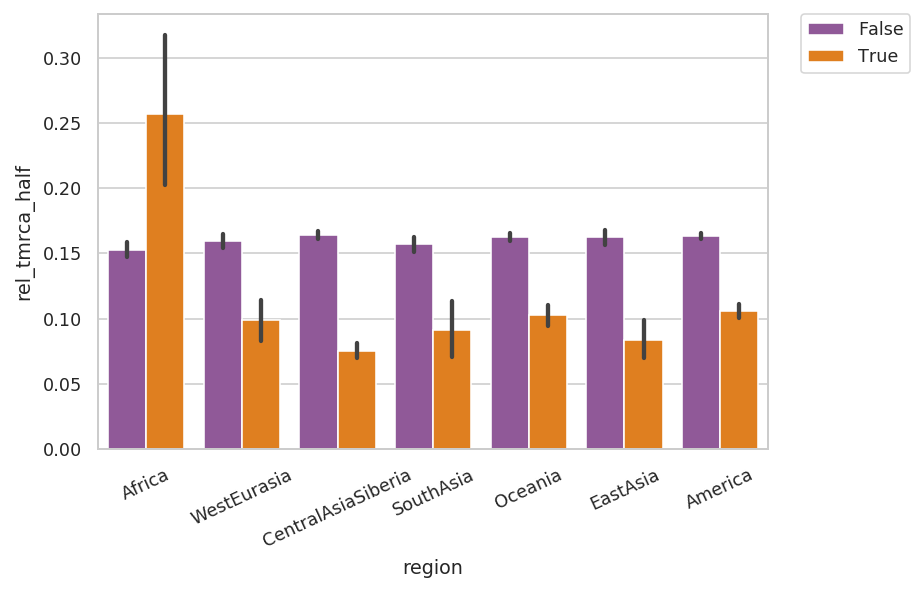

In [62]:
with sns.plotting_context('paper'):
    with sns.axes_style('whitegrid'):
        with sns.color_palette([set1['purple'], set1['orange']]):
            g = sns.barplot(x="region", y="rel_tmrca_half", hue="is_low_region", data=df,
                           order=region_categories)
            for item in g.get_xticklabels():
                item.set_rotation(25)
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(str(figures_dir / "tmrca_half_contrast_by_region.pdf"))

This is consistent also if we look at low pi regions only found in one region.

### TMRCA

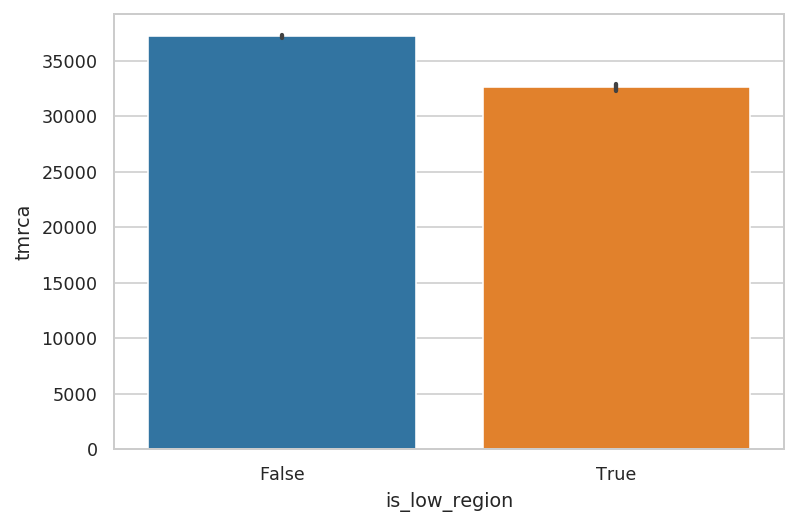

In [63]:
sns.barplot(x="is_low_region", y="tmrca", data=df);

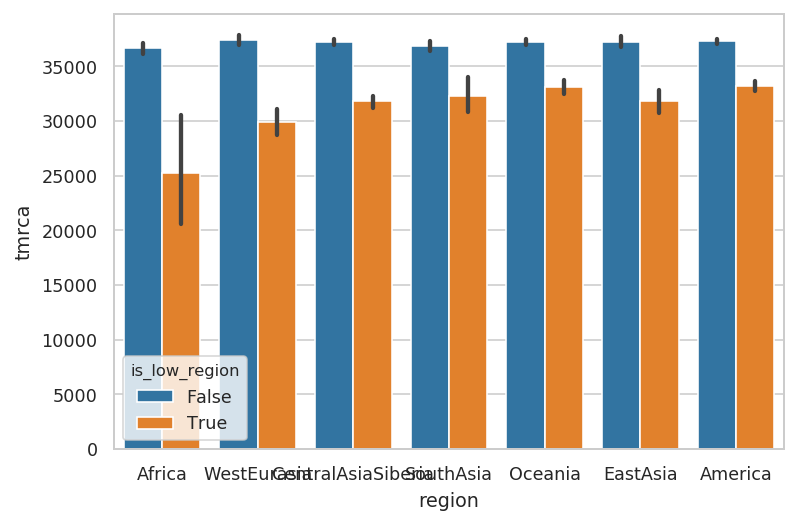

In [64]:
sns.barplot(x="region", y="tmrca", hue="is_low_region", data=df) ;

That is also the case for the TMRCA. Could just be lower Ne in the regions (pos and/or neg sel). Popentially also contributing: if the some of the low regions originate from a first wave african variant that was later selected on interaction with the second wave. If this is true then it means that the common ancestor of the selected variant from the first wave would have arissen later than the mean TMRCA of all humnas (though not likely).

The prediction is that if we look at only low pi regions in a single region and compare to rel_tmrca_half for trees sampled from only that region, they we will not see a strong depression in rel_tmrca_half. 

The relative tmrca half in the low pi (sweept) regions roughly represent the time of the sweep. So if rel tmrca half is not smaller than outside low pi regions, it must mean that the sweep happened quite early in the region coalescent trees, or if they are lower, even before as part of wave 2.

In [65]:
plot_df = (pandas.merge(abs_low_window_chrX_df,
                   tmrca_stats.loc[lambda df: df.region != 'World', ['region', 'start', 'end',
                                                                        'rel_tmrca_half', 'tmrca']],
                   on=['region', 'start', 'end'])
        .assign(is_low_region = lambda df: (df.islow) & (df.run >= min_run_length))
     )
plot_df.head()

,index,chrom,start,end,pop_label,region_label,pi,run,islow,run_id,region,population,is_low_region,rel_tmrca_half,tmrca
0,0,X,0,100000,Bougainville,Oceania,NaN,900,False,1,Oceania,Bougainville,False,0.214871,39827.147233
1,0,X,0,100000,Dusun,Oceania,NaN,841,False,1,Oceania,Dusun,False,0.214871,39827.147233
2,0,X,0,100000,Papuan,Oceania,NaN,2704,False,1,Oceania,Papuan,False,0.214871,39827.147233
3,1,X,100000,200000,Bougainville,Oceania,NaN,900,False,1,Oceania,Bougainville,False,0.246370,47440.013675
4,1,X,100000,200000,Dusun,Oceania,NaN,841,False,1,Oceania,Dusun,False,0.246370,47440.013675


In [ ]:
g = sns.factorplot(x='is_low_region', y='rel_tmrca_half', col='region', data=plot_df, kind='bar', 
               col_wrap=4, height=4, aspect=0.5)